In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext rpy2.ipython

import copy
import itertools
import matplotlib.pyplot as plt
import MESS
import numpy as np
import pandas as pd
import random
import toytree

from collections import Counter

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 500)

In [162]:
def bm(mean, var, log=True, dtype="int"):
    ret = 0
    if dtype == "int":
        # Avoid log(1)
        if not log or mean <= 1:
            ret = np.int(np.round(np.random.normal(mean, var)))
        else:
            ret = np.int(np.round(np.exp(np.random.normal(np.log(mean), var))))
    elif dtype == "float":
        ret = np.random.normal(mean, var)
    else:
       raise Exception("bm dtype must be 'int' or 'float'. You put: {}".format(dtype))
    return ret

def prune(tre, verbose=False):
    ttree = tre.copy()
    tips = ttree.treenode.get_leaves()
    
    if np.any(np.array([x.height for x in tips]) > 0):
        for t in tips:
            if not np.isclose(t.height, 0):
                if verbose: print("Removing node/height {}/{}".format(t.name, t.height))
                t.delete(prevent_nondicotomic=False)
                ttree = prune(ttree)
    return ttree

bm(1, .1, log=True)

1

In [29]:
bdtre = toytree.rtree.bdtree(b=1, d=.7, n=10)
bdtre.draw()

(<toyplot.canvas.Canvas at 0x7f69f0d6c940>,
 <toyplot.coordinates.Cartesian at 0x7f69f0e13278>)

<svg class="toyplot-canvas-Canvas" height="275.0px" id="t6e6516b42c0645fb8b9773b21f607c0d" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 260.0 275.0" width="260.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> r0 r1 r2 r3 r4 r5 r6 r7 r8 r9

# bd todos

In [179]:
# Should we implement a death rate parameter too? If ancestral abundance is super high
# which we'd expect if we're dividing at each branch, then the extinction rate is really
# low
def bd_ibm(b=1, stop="taxa", n=50, t=4, feature_dict=None, process="abundance", verbose=False):
    if not feature_dict:
        feature_dict = {"abundance":{"sigma":0.7, "zbar_0":50000, "log":True, "dtype":"int"},
                      "r":{"sigma":0.1, "zbar_0":0, "log":False, "dtype":"float"},
                      "trait":{"sigma":2, "zbar_0":0, "log":False, "dtype":"float"}
                     }

    tre = toytree.tree()
    for fname, fdict in feature_dict.items():
        tre.treenode.add_feature(fname, fdict["zbar_0"])

    taxa_stop = n
    time_stop = t

    ext = 0
    evnts = 0
    t = 0
    while(1):

        ## Get list of extant tips
        tips = tre.treenode.get_leaves()

        # Sample time interval
        dt = np.random.exponential(1/(len(tips) * b))
        t = t + dt
        evnts += 1
        
        sp = np.random.choice(tips)
        c1 = sp.add_child(name=str(t)+"1", dist=0)
        c2 = sp.add_child(name=str(t)+"2", dist=0)
        try:
            # Always have at least 1 individual for each daughter species
            abund = np.random.randint(1, sp.abundance)
        except Exception as inst:
            # If a species of abundance 1 speciates we need to allow this
            sp.abundance = 2
            abund = 1

        for c in [c1, c2]:
            for fname, fdict in feature_dict.items():
                c.add_feature(fname, fdict["zbar_0"])
                
        c1.add_feature("abundance", abund)
        c2.add_feature("abundance", sp.abundance-abund)


        # Update branch length, evolve features, and update abundance
        tips = tre.treenode.get_leaves()
        for x in tips:
            x.dist += dt
            if process == "abundance":
                for fname, fdict in feature_dict.items():
                    x.add_feature(fname, bm(getattr(x, fname),
                                            fdict["sigma"],
                                            log=fdict["log"],
                                            dtype=fdict["dtype"]))
            elif process == "rate":
                for fname, fdict in feature_dict.items():
                    # Update 'r' and 'trait', but skip 'abundance'
                    #import pdb; pdb.set_trace()
                    if fname == "abundance": continue
                    x.add_feature(fname, bm(getattr(x, fname),
                                            fdict["sigma"],
                                            log=fdict["log"],
                                            dtype=fdict["dtype"]))
                    # Apply the population size change
                    x.abundance = int(x.abundance * (np.exp(x.r)**dt))
            else:
                raise Exception("process must be 'abundance' or 'rate'. You put {}".format(process))

        # Check extinction and prune out extinct and any resulting hanging branches
        tips = tre.treenode.get_leaves()
        for x in tips:
            if x.abundance <= 0:
                x.delete(preserve_branch_length=True, prevent_nondicotomic=False)
                ext += 1
        tre = prune(tre)

        tips = tre.treenode.get_leaves()
        # Check stopping criterion
        done = False
        if stop == "taxa":
            if len(tips) >= taxa_stop:
                done = True
        elif stop == "time":
            if t >= time_stop:
                done = True
        elif len(tips) == 0:
            print("All lineages extinct")
            done = True
        if done:
            if verbose:
                print("Birth events {}".format(evnts))
                print("Extinctions (per birth) {} ({})".format(ext, ext/evnts))
            tre._coords.update()
            for i, t in enumerate(tips[::-1]):
                t.name = "r{}".format(i)
            return tre


tre = bd_ibm(b=2, stop="taxa", n=50, t=10, process="rate", verbose=True)

tips = tre.treenode.get_leaves()
for feat in ["abundance", "r", "trait"]:
    labs = [str(getattr(x, feat)) for x in tips]
    tre.draw(tip_labels=labs)
# Iff one species remains and you try to 'draw()' you get this error
# can generate by setting abundance very low. not sure why it's doing this yet.
# 'list' object has no attribute 'shape'

Birth events 132
Extinctions (per birth) 83 (0.6287878787878788)


<svg class="toyplot-canvas-Canvas" height="900.0px" id="tf03cf03635e14fee9d35c1b77b1d0d23" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 270.0 900.0" width="270.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> 57 21 39 6 1 3 1045 4311 51 413 75 358 171 87 46 640 491 197 318 507 3744 4 3 7859 4256 363 333 77 540 141 153 8221 39 8 19 29 80 5314 584 2003 1631 185 3711 32 4 10 44 111 8 426

<svg class="toyplot-canvas-Canvas" height="900.0px" id="t60ce0bad2b054849a10cba6406eb4a66" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 355.0 900.0" width="355.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> 0.728850274711039 0.5344791268035508 -0.1783320005463024 0.7912167823237829 0.22019873276553645 0.07160935631219331 -0.5986725909909325 0.04591886386718946 0.32659230262252914 0.426092044761669 0.12079115193509521 -0.7328621048356336 0.23269301732605216 0.03878063557578185 -0.10773883081804288 0.2592254973775251 -0.19853798725608707 -0.5812492065491428 -0.10888251097548232 0.07239598367207657 0.9614018635064243 -0.11866850897876696 0.06930568464342027 -0.07780341665338578 0.015856822736318166 -0.049681503395598736 0.4916017273892496 -0.2878607486899967 0.1029175663439208 0.5038814751689312 0.83201955795844 0.35149289164407815 0.11674341592259027 0.3762976982638569 0.4242457308692187 0.540382215966385 0.06976136140881639 -1.3491607499271154 0.030997465475674724 -0.016285507093885737 -0.03384951019998063 -0.663419291644928 -0.20886131307645633 -0.7007603765961539 -0.24850969498564993 0.2625393379634474 0.10154709923133769 0.30029502148591 0.22981066444717257 -0.3036335323245628

<svg class="toyplot-canvas-Canvas" height="900.0px" id="tc0f5f4ddaacb48379afd788c50772983" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 350.0 900.0" width="350.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> -3.285132470623949 -0.9035234518678118 6.632805611361853 -5.544323116618012 -0.04389106844723045 0.8674955905290289 -5.358598929293629 6.757799737830343 -5.068261395709189 29.271259376009493 -4.540320294579708 8.106338568951351 -1.3285551019916233 -11.427494591158085 7.370593078689418 3.356062406186724 -4.650313514516319 2.4173735931360723 3.6854840191431 -9.82937555356408 -1.7630625922757146 1.2100288712330587 4.648653761605056 -1.1013629796178233 -3.762888465807884 9.17826272345537 -1.741499876164288 13.166239247321236 -9.572786096971809 2.9782514403155425 -10.922201732857044 -9.677104925135081 -2.3488389211895027 4.537147177167007 7.056312105746341 -4.399433674453231 0.7864331752281375 -13.670255543814514 -19.888788057938115 -9.27567252158238 0.35829087924106584 -14.598507729628345 32.86632355778826 -3.8525800123900686 0.785981447338431 -0.6990727583353299 -0.1977722417167499 -1.2764003384458977 -2.779017667142801 14.059404036750964

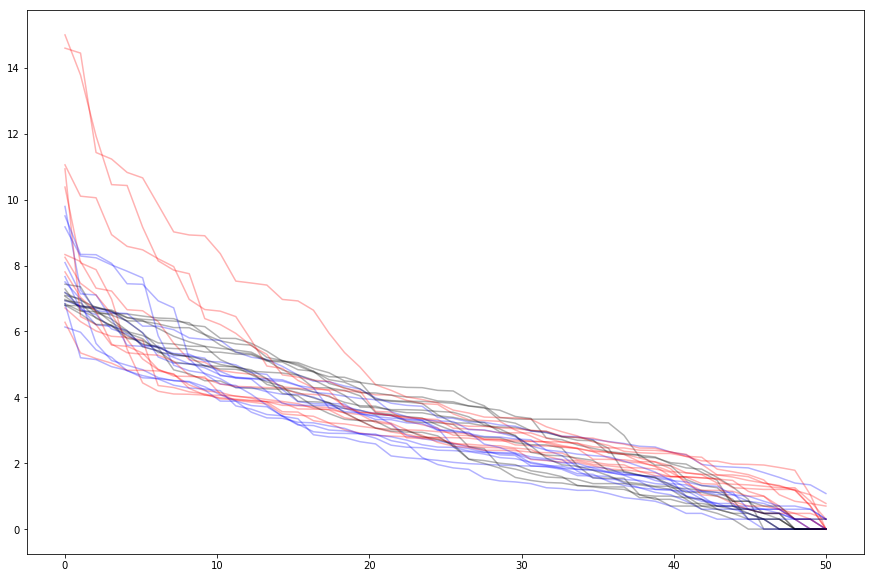

In [225]:
fig, ax = plt.subplots(figsize=(15, 10))
for _ in range(10):
    xs = np.linspace(0, len(abunds), len(abunds))

    for c, p in zip(["red", "blue"], ["rate", "abundance"]):
        tre = bd_ibm(b=.2, stop="taxa", n=50, t=4, process=p, verbose=False)
        tips = tre.treenode.get_leaves()
        abunds = np.array([x.abundance for x in tips])
        abunds = sorted(abunds, reverse=True)
        ys = np.log10(abunds)
        plt.plot(xs, ys, c=c, alpha=0.3)

    ys = np.log10(sorted(np.random.logseries(0.9999999, size=len(abunds)), reverse=True))
    plt.plot(xs, ys, c='black', alpha=0.3)

## This is the "working" bd_ibm using only split abundances

In [42]:
# Should we implement a death rate parameter too? If ancestral abundance is super high
# which we'd expect if we're dividing at each branch, then the extinction rate is really
# low
def bd_ibm(b=1, stop="taxa", n=50, t=4, sigma=1, abundance=500000, verbose=False):

    tre = toytree.tree()
    tre.treenode.add_feature("abundance", abundance)

    taxa_stop = n
    time_stop = t

    ext = 0
    evnts = 0
    t = 0
    while(1):
        tips = tre.treenode.get_leaves()
        # Check extinction
        for x in tips:
            if x.abundance <= 0:
                x.delete(preserve_branch_length=True, prevent_nondicotomic=False)
                ext += 1
        tre = prune(tre)

        ## Get list of extant tips
        tips = tre.treenode.get_leaves()

        # Sample time interval
        dt = np.random.exponential(1/(len(tips) * b))
        t = t + dt
        evnts += 1
        
        sp = np.random.choice(tips)
        c1 = sp.add_child(name=str(t)+"1", dist=0)
        c2 = sp.add_child(name=str(t)+"2", dist=0)
        try:
            # Always have at least 1 individual for each daughter species
            abund = np.random.randint(1, sp.abundance)
        except Exception as inst:
            # If a species of abundance 1 speciates we need to allow this
            sp.abundance = 2
            abund = 1
        c1.add_feature("abundance", abund)
        c2.add_feature("abundance", sp.abundance-abund)

        # Update branch length and perturb abundance
        tips = tre.treenode.get_leaves()
        for x in tips:
            x.dist += dt
            x.abundance = bm(x.abundance, sigma, log=True)

        # Check stopping criterion
        done = False
        if stop == "taxa":
            if len(tips) >= taxa_stop:
                done = True
        elif stop == "time":
            if t >= time_stop:
                done = True
        elif len(tips) == 0:
            print("All lineages extinct")
            done = True
        if done:
            if verbose:
                print("Time {}".format(t))
                print("Ntips {}".format(len(tips)))
                print("Birth events {}".format(evnts))
                print("Extinctions (per birth) {} ({})".format(ext, ext/evnts))
            tre._coords.update()
            for i, t in enumerate(tips[::-1]):
                t.name = "r{}".format(i)
            return tre


tre = bd_ibm(b=.2, stop="taxa", n=20, t=10, sigma=.7, abundance=1, verbose=True)

tips = tre.treenode.get_leaves()
abunds = [str(x.abundance) for x in tips]
tre.draw(tip_labels=abunds)
tre.draw()
# Iff one species remains and you try to 'draw()' you get this error
# can generate by setting abundance very low. not sure why it's doing this yet.
# 'list' object has no attribute 'shape'

Time 39.1771962923205
Ntips 20
Birth events 45
Extinctions (per birth) 26 (0.5777777777777777)


(<toyplot.canvas.Canvas at 0x7f69f0cf80b8>,
 <toyplot.coordinates.Cartesian at 0x7f69f16c61d0>)

<svg class="toyplot-canvas-Canvas" height="360.0px" id="t33dd0beaa0be47bc8d831a546b7b0ece" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 270.0 360.0" width="270.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> 1 12 597 1314 241 897 8 14 3 9 1129 5 70 16 37 1 88 29 19 2

<svg class="toyplot-canvas-Canvas" height="360.0px" id="t79800dac12db4080be5f7b18a3c95e5c" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 265.0 360.0" width="265.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> r0 r1 r2 r3 r4 r5 r6 r7 r8 r9 r10 r11 r12 r13 r14 r15 r16 r17 r18 r19

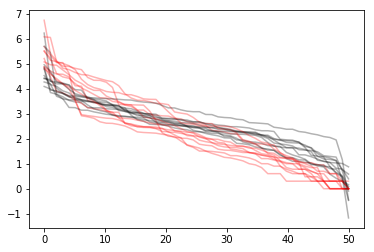

In [28]:
# abundance only bd tree
for _ in range(10):
    
    tre = bd_rate(b=.2, stop="taxa", n=50, t=4, sigma=0.5, abundance=10000, verbose=False)
    tips = tre.treenode.get_leaves()
    abunds = np.array([x.abundance for x in tips])
    #plt.hist(np.log10(abunds), bins=20)
    abunds = sorted(abunds, reverse=True)
    xs = np.linspace(0, len(abunds), len(abunds))
    ys = np.log10(abunds)
    plt.plot(xs, ys, c="red", alpha=0.3)

    plt.plot(xs, np.log(sorted(np.random.lognormal(2.5, 1, len(abunds)), reverse=True)), c='black', alpha=0.3)

## Trash below here

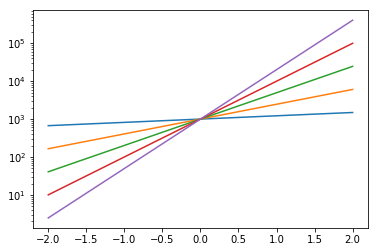

In [177]:
# How reproductive rate function workds
N0 = 1000
rs = np.linspace(-2, 2, 50)
for t in np.linspace(0.2, 3, 5):
    plt.semilogy(rs, N0* np.exp(rs*t))

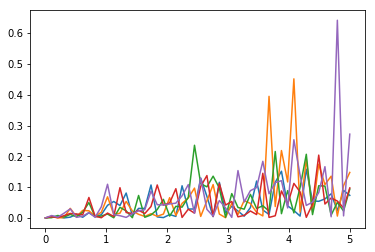

In [171]:
tips = 40
bs = np.linspace(0, 5)
for _ in range(5):
    plt.plot(bs, np.random.exponential(1/tips * bs))


In [184]:
# This works, but the notion of time is fucked up, it's not
# per lineage, it's per birth event.
def bd_timesteps(steps=50, abundance=500000):
    tre = toytree.tree()
    tre.treenode.add_feature("abundance", abundance)

    for s in range(steps):
        tips = tre.treenode.get_leaves()

        # Check extinction
        for x in tips:
            if x.abundance <= 0:
                x.delete(preserve_branch_length=True, prevent_nondicotomic=False)

        tips = tre.treenode.get_leaves()
        sp = np.random.choice(tips)
        #sp.dist += 1
        c1 = sp.add_child(name=str(s)+"1", dist=0)
        c2 = sp.add_child(name=str(s)+"2", dist=0)
        abund = np.random.randint(1, sp.abundance)
        c1.add_feature("abundance", abund)
        c2.add_feature("abundance", sp.abundance-abund)

        # Update branch length and perturb abundance
        for x in tips:
            x.dist += 1
            x.abundance = bm(x.abundance, 100, log=False)

        tre = prune(tre)
    return tre
tre = bd_timesteps()
tre.draw()

(<toyplot.canvas.Canvas at 0x7f52a722fda0>,
 <toyplot.coordinates.Cartesian at 0x7f52a71e3208>)

<svg class="toyplot-canvas-Canvas" height="702.0px" id="td5c7649a9fe94654a29b9d312af88761" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 265.0 702.0" width="265.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> 342 392 391 132 422 421 142 442 441 82 262 431 291 332 462 461 361 411 482 481 471 492 491 122 372 371 322 321 402 401 252 382 452 451 231 192 191 172 311

In [267]:
%%R
rexp(20, 10)

 [1] 0.44219855 0.03608151 0.06805857 0.07579760 0.22339966 0.10209516
 [7] 0.12705568 0.05505301 0.12929021 0.15964229 0.09088534 0.01934587
[13] 0.02880004 0.03312176 0.15023076 0.16136473 0.01010390 0.03459232
[19] 0.04028929 0.10390063
